In [43]:
import matplotlib.pyplot as plt
import tensorflow as tf
import heartpy as hp
import pandas as pd
import numpy as np 
import pywt as pw
import pickle
import tsfel

2023-10-30 18:23:50.864102: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 18:23:50.883066: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 18:23:50.883099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 18:23:50.883112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 18:23:50.886949: I tensorflow/core/platform/cpu_feature_g

### Load RAW DataSet as dict from .pkl file
https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/heartpy.heartpy.html#filtering

In [2]:
raw_data = {}
data_set_path = '../data_set_raw_ECG/raw_data_dict.pkl'

with open(data_set_path, 'rb') as f:
    raw_data = pickle.load(f)
print("RAW dataset has been loaded...")
print("Data hierarchy goes as follows: \n\n")
print(raw_data.keys())
print("- " + str(raw_data['participant_1'].keys()))
print("-- " + str(raw_data['participant_1']['ECG'].keys()))
print("--- " + str(len(raw_data['participant_1']['ECG']['baseline'])))

RAW dataset has been loaded...
Data hierarchy goes as follows: 


dict_keys(['participant_1', 'participant_10', 'participant_11', 'participant_12', 'participant_13', 'participant_14', 'participant_15', 'participant_16', 'participant_17', 'participant_18', 'participant_19', 'participant_2', 'participant_20', 'participant_21', 'participant_22', 'participant_23', 'participant_3', 'participant_4', 'participant_5', 'participant_6', 'participant_7', 'participant_8', 'participant_9'])
- dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
-- dict_keys(['baseline', 'stimuli'])
--- 18


In [3]:
num_of_participants = 23
num_of_clips = 18

#In Hz:
low_frequency = 0.75
high_frequenc = 5 
def data_filter (data):
    # Separate data by channel
    for participant in data.keys():
        print("Starting " + participant)
        for clip_num in range(0, num_of_clips):
            # Filter both channels from baseline
            CH1 = [row[0] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = low_frequency, sample_rate = 256.0, order = high_frequenc, filtertype='highpass')
            
            CH2 = [row[1] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = low_frequency, sample_rate = 256.0, order = high_frequenc, filtertype='highpass')
            
            filtered = np.column_stack((CH1_filtered, CH2_filtered))
            
            data[participant]['ECG']['baseline'][clip_num] = filtered
            
            # Filter both channels from stimuli
            CH1 = [row[0] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = low_frequency, sample_rate = 256.0, order = high_frequenc, filtertype='highpass')
            
            CH2 = [row[1] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = low_frequency, sample_rate = 256.0, order = high_frequenc, filtertype='highpass')
            
            filtered = np.column_stack((CH1_filtered, CH2_filtered))
            
            data[participant]['ECG']['stimuli'][clip_num] = filtered
            
            print("Done filtering raw for " + participant + " at clip#" + str(clip_num+1))
    print("All done.... Highpass filter applied, cutoff: " + str(low_frequency) + "Hz and order: " + str(high_frequenc) + "Hz")
    return data
            
            

### Filter data and create new dict

In [4]:
filtered_data = data_filter(raw_data)

Starting participant_1
Done filtering raw for participant_1 at clip#1
Done filtering raw for participant_1 at clip#2
Done filtering raw for participant_1 at clip#3
Done filtering raw for participant_1 at clip#4
Done filtering raw for participant_1 at clip#5
Done filtering raw for participant_1 at clip#6
Done filtering raw for participant_1 at clip#7
Done filtering raw for participant_1 at clip#8
Done filtering raw for participant_1 at clip#9
Done filtering raw for participant_1 at clip#10
Done filtering raw for participant_1 at clip#11
Done filtering raw for participant_1 at clip#12
Done filtering raw for participant_1 at clip#13
Done filtering raw for participant_1 at clip#14
Done filtering raw for participant_1 at clip#15
Done filtering raw for participant_1 at clip#16
Done filtering raw for participant_1 at clip#17
Done filtering raw for participant_1 at clip#18
Starting participant_10
Done filtering raw for participant_10 at clip#1
Done filtering raw for participant_10 at clip#2
Do

In [5]:
### Function to display graph
def show_graph(filtered_data,participant, clip, dtype, range_min = 0, range_max = -1):
    plt.plot(filtered_data[participant]['ECG'][dtype][clip][range_min:range_max])
    plt.ylabel("mV")
    plt.xlabel("Sample #")
    graph_title = participant + "  clip#" + str(clip) + " " + dtype + " data range: " + str(range_min) + " => " + str(range_max)
    plt.title(graph_title)

### Function to split channels
def chan_split(participant, clip, dtype):
    ch1 = [row[0] for row in filtered_data[participant]['ECG'][dtype][clip]]
    ch2 = [row[1] for row in filtered_data[participant]['ECG'][dtype][clip]]
    
    return ch1, ch2

### Function to plot Heard Rate Signal Peak Detection
def peak_detection(participant, clip, dtype, ch = 1, range_min = 0, range_max = -1):
    
    p1_c1_ch1, p1_c1_ch2 =(chan_split(participant, clip, dtype))
    wd1 = hp.process(p1_c1_ch1[range_min:range_max], 256)
    wd2 = hp.process(p1_c1_ch1[range_min:range_max], 256)
    if ch == 1:
        hp.plotter(wd1[0], wd1[1])
    else:
        hp.plotter(wd2[0], wd2[1])

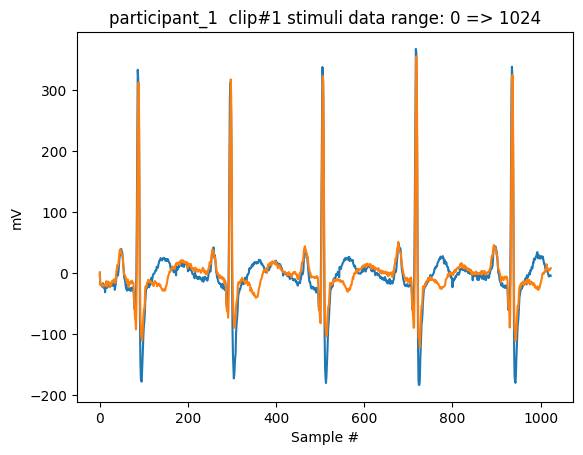

In [6]:
show_graph('participant_1', 1, 'stimuli', 0, 1024)

dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare', 'breathing_signal', 'breathing_psd', 'breathing_frq'])
dict_keys(['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate'])


c:\ProgramData\anaconda3\envs\DREAMER\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


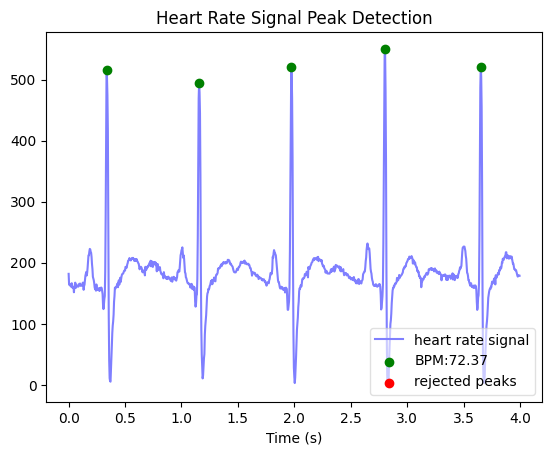

In [7]:
p1_c1_ch1, p1_c1_ch2 =(chan_split('participant_1', 1, 'stimuli'))
wd1 = hp.process(p1_c1_ch1[0:1024], 256)
wd2 = hp.process(p1_c1_ch1[0:1024], 256)
#result = np.column_stack((wd1, wd2))
print(wd1[0].keys())
print(wd2[1].keys())

hp.plotter(wd1[0], wd2[1])

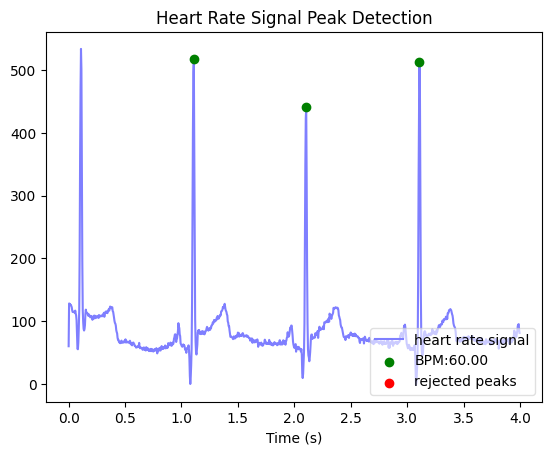

In [8]:
peak_detection('participant_23', 1, 'stimuli', range_min = 0, range_max = 1024)

## Feature Extraction
### - Time Domain Features:
These are statistical features extracted from the ECG signal in the time domain. They include features like the mean, standard deviation, skewness, and kurtosis of the ECG signal
### - Frequency Domain Features:
These are features extracted from the frequency representation of the ECG signal. They include features like the power spectral density, spectral entropy, and dominant frequency
### - Decomposition and Sparse Domain Features
These are features extracted by decomposing the ECG signal into its constituent parts
### - Deep Features
These are high-level features automatically extracted by deep learning models from the raw ECG signal. For example, a CNN-LSTM hybrid model or an attention/transformer-based model with wavelet transform for dimensional embedding can be used for automatic feature extraction
https://link.springer.com/article/10.1007/s11760-022-02194-3

In [9]:
# Time Domain
cfg = tsfel.get_features_by_domain()
X = tsfel.time_series_features_extractor(cfg, p1_c1_ch1)
X

*** Feature extraction started ***


C:\Users\ErnestoSola-Thomas\AppData\Local\Temp\ipykernel_12744\2682754319.py:3: UserWarning: Using default sampling frequency set in configuration file.
  X = tsfel.time_series_features_extractor(cfg, p1_c1_ch1)



*** Feature extraction finished ***


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_0,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate
0,1.285816e+08,9729.81673,1.285816e+08,383425.185819,170.935602,6707.0,26828.0,-20.118519,13.485022,0.00003,...,512.740341,6038.569602,15416.068296,22369.051334,25399.410667,25800.70092,25020.51088,23751.264348,22091.913789,2158.0


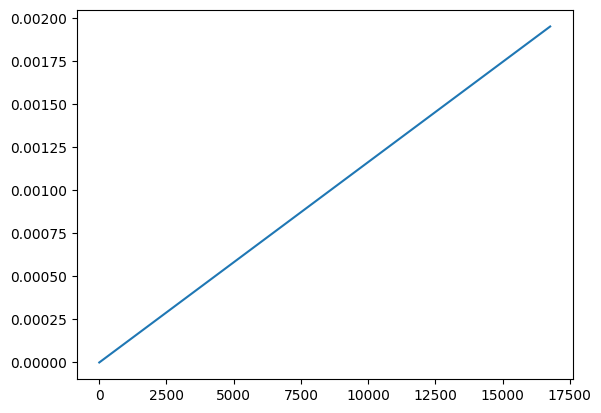

In [10]:
# Frequency Domain
freq = np.fft.rfftfreq(len(p1_c1_ch1), 256)
plt.plot(freq)

# https://stackoverflow.com/questions/68676264/how-to-do-features-extraction-of-ecg-using-mean-frequency-in-python

 ...]

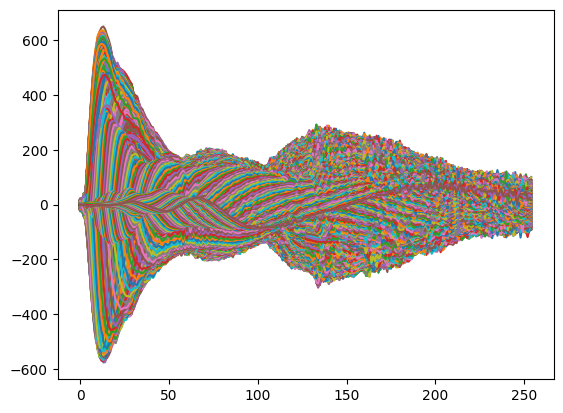

In [13]:
# Time-Frequency Domain

scales =  range(1, 256)
waveletname = 'morl'
#waveletname = 'auto'

coeff, freq = pw.cwt(p1_c1_ch1, scales, waveletname, 1)

#plt.plot(coeff)
# https://tkhan11.github.io/blog/timeSeriesFeatExt.html

In [27]:
filtered_data['participant_1']['ECG']['stimuli'][1]

array([[ -1.31722839,   1.366247  ],
       [-19.07775552, -18.2802701 ],
       [-18.83842476, -17.92629422],
       ...,
       [ -4.14710352,   1.58542053],
       [ -6.56755448,  -1.17873306],
       [ -4.97084413,  -0.92610963]])

In [48]:
#def load_data():
    # Load your ECG data and the corresponding scores here
    # X should be your ECG data
    # y should be a matrix containing the scores of Valence, Arousal, Dominance
    
X, y_valence, y_arousal, y_dominance = [], [], [], []

for i in range(1, 23):
    participant_data = filtered_data['participant_' + str(i)]
    print(participant_data.keys())
    for j in range(1,18):
        print(j)
        ecg_data = participant_data['ECG']['stimuli'][j]
        X.append(ecg_data)
        
        valence_score = participant_data['ScoreValence'][j]
        arousal_score = participant_data['ScoreArousal'][j]
        dominance_score = participant_data['ScoreDominance'][j]
        
        y_valence.append(valence_score)
        y_arousal.append(arousal_score)
        y_dominance.append(dominance_score)

y = np.column_stack((y_valence, y_arousal, y_dominance))
y
    #return tf.data.Dataset.from_tensor_slices((X, y))


dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9


array([[3, 3, 1],
       [5, 4, 4],
       [4, 3, 2],
       ...,
       [4, 3, 4],
       [2, 3, 3],
       [3, 4, 4]])

In [45]:
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3)  # Output layer has 3 neurons corresponding to the 3 scores
    ])
    
    return model

def compile_model(model):
    model.compile(optimizer='adam',
                  loss='mean_squared_error')


In [46]:
ml_data = load_data()

dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
dict_keys(['Age', 'Gender', 'ECG', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])
1
2
3
4
5
6
7
8
9


2023-10-30 18:24:06.052337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


ValueError: Can't convert non-rectangular Python sequence to Tensor.